# dominating set

Set up calculations and store in EspressoDB

In [1]:
import matplotlib.pylab as plt
import seaborn as sns
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import graph_summary, experiment_summary, data_summary, insert_result, QUBO_to_Ising

from networkx import Graph
from networkx.algorithms.approximation import min_weighted_dominating_set

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

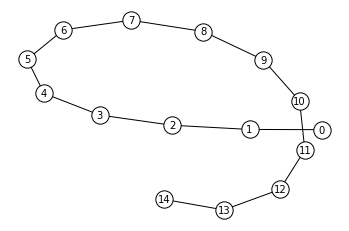

{'tag': 'NN(15)',
 'total_vertices': 15,
 'total_edges': 14,
 'max_edges': 2,
 'adjacency': [[0, 1],
  [1, 2],
  [7, 8],
  [6, 7],
  [10, 11],
  [4, 5],
  [5, 6],
  [12, 13],
  [11, 12],
  [13, 14],
  [8, 9],
  [9, 10],
  [2, 3],
  [3, 4]],
 'adjacency_hash': 'd334ac82b47485491d807f3dd1a38677'}

In [3]:
# Define Adjacency matrix
# Hamming(d,q)
# Biparti
# NN(v): 1D nearest neighbor with v vertices. max is 16 before minor embedding starts breaking
graph, tag = gt.generate_hamming_graph(2, 3)
#graph, tag = gt.generate_bipartite_graph(3, 3)
graph, tag = gt.generate_nn_graph(15)
penalty = 2

directed = False
qubo = get_mds_qubo(graph, directed=directed, penalty = penalty, triangularize=True, dtype="d")
q_min = np.array(list(qubo.values())).min()

gt.get_plot(graph, directed=directed)
plt.show()
graph_params = graph_summary(tag, graph)
graph_params

In [4]:
J, h, C = QUBO_to_Ising(qubo.todense().tolist())
maxJ = max(abs(J).flatten())
maxh = max(abs(h))
print("Initial")
print(f"max(J) = {maxJ}")
print(f"max(h) = {maxh}")
print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
print("Must scale QUBO to these ranges\n")
fact = 1 #max([maxJ, maxh/2]) * 1.2
qubo = qubo / fact

J, h, C = QUBO_to_Ising(qubo.todense().tolist())
maxJ = max(abs(J).flatten())
maxh = max(abs(h))
print("Rescaled")
print(f"max(J) = {maxJ}")
print(f"max(h) = {maxh}")
print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
print("Must scale QUBO to these ranges\n")

# Set chain strength
chain_strength = max(np.abs(list(qubo.values()))) * 0.5
print(f"Chain strength: {chain_strength}")

Initial
max(J) = 2.0
max(h) = 5.5
DWave J_range = [-1.0, 1.0] 
DWave h_range = [-2.0, 2.0]
Must scale QUBO to these ranges

Rescaled
max(J) = 2.0
max(h) = 5.5
DWave J_range = [-1.0, 1.0] 
DWave h_range = [-2.0, 2.0]
Must scale QUBO to these ranges

Chain strength: 8.0


In [5]:
#classical_search(qubo)

In [6]:
# DWave settings
dwave_config = {
    "annealing_time": 500,  # integer microseconds [1, 2000]
    "answer_mode": "histogram",
    "auto_scale": True,
    "num_reads": 1000,  # raw will dump out all results
    "num_spin_reversal_transforms": 0,
    "readout_thermalization": 0, # default 0
    "programming_thermalization": 1000, # default 1000
    "chain_strength": chain_strength
}
solver = "DW_2000Q_5"

experiment_params = experiment_summary(machine=solver, settings=dwave_config, penalty=penalty, factor=fact, qubo=qubo)

In [7]:
# Solve on DWave and push to database
sampler = DWaveSampler(solver=solver)
embed = EmbeddingComposite(sampler)
qubo_dict = {key: val for key, val in zip(qubo.keys(), qubo.values())}
for idx in range(1):
    print(idx)
    result = embed.sample_qubo(qubo_dict, **dwave_config)
    raw = result.to_pandas_dataframe()
    data_params = data_summary(raw, graph_params, experiment_params)
    #result = insert_result(graph_params, experiment_params, data_params)
print(raw.sort_values("energy", ascending=True))

0
     0  1  2  3  4  5  6  7  8  9  ...  36  37  38  39  40  41  42  \
0    0  1  1  0  0  1  0  0  1  0  ...   0   0   0   0   0   0   0   
1    0  1  0  1  0  0  1  0  0  1  ...   0   0   1   0   1   0   0   
15   1  0  1  0  0  1  0  0  1  1  ...   0   0   1   0   1   0   0   
14   1  0  1  0  0  1  0  0  1  1  ...   0   0   0   0   0   0   0   
12   0  1  0  1  0  0  1  1  1  0  ...   0   0   0   0   0   0   0   
..  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..   
991  1  0  1  1  0  0  0  0  1  0  ...   0   0   1   0   1   0   0   
992  0  1  0  0  0  1  1  1  1  1  ...   1   0   0   0   0   1   1   
993  0  1  0  0  1  1  0  0  1  1  ...   0   0   0   0   0   0   0   
994  0  0  1  0  1  1  0  1  0  1  ...   0   1   1   0   1   0   0   
998  1  0  0  1  0  1  0  0  1  0  ...   1   0   1   0   1   0   0   

     chain_break_fraction  energy  num_occurrences  
0                0.000000   -24.0                1  
1                0.000000   -24.0                1 